<a href="https://colab.research.google.com/github/leeuz/Machine-Learning-Validation-of-TESS-Transit-Light-Curves/blob/main/nasa_schar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lightkurve scikit-learn matplotlib numpy pandas

import lightkurve as lk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
# TOI ID list
toi_list = ["TIC 456401439", "TIC 286857537", "TIC 88101924"]

# 1=exoplanet, 0=bad data
labels = [1, 0, 1]

In [ ]:
def extract_transit_features(lc):
    flux = lc.flux.value
    time = lc.time.value

    mean_flux = np.mean(flux)
    std_flux = np.std(flux)
    skew_flux = pd.Series(flux).skew()
    min_flux = np.min(flux)
    max_flux = np.max(flux)
    flux_range = max_flux - min_flux
    depth = mean_flux - min_flux
    low_flux = flux < (mean_flux - depth/2)
    duration = np.sum(low_flux) * (time[1]-time[0])

    features = {
        "mean_flux": mean_flux,
        "std_flux": std_flux,
        "skew_flux": skew_flux,
        "min_flux": min_flux,
        "max_flux": max_flux,
        "flux_range": flux_range,
        "transit_depth": depth,
        "transit_duration": duration
    }
    return features

In [ ]:
X = df.drop(["label","TOI"], axis=1)
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)
if y_prob.shape[1] > 1:
    y_prob = y_prob[:, 1]
else:
    y_prob = y_prob[:, 0]


print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.00      0.00      0.00         0

    accuracy                           0.50         2
   macro avg       0.50      0.25      0.33         2
weighted avg       1.00      0.50      0.67         2



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


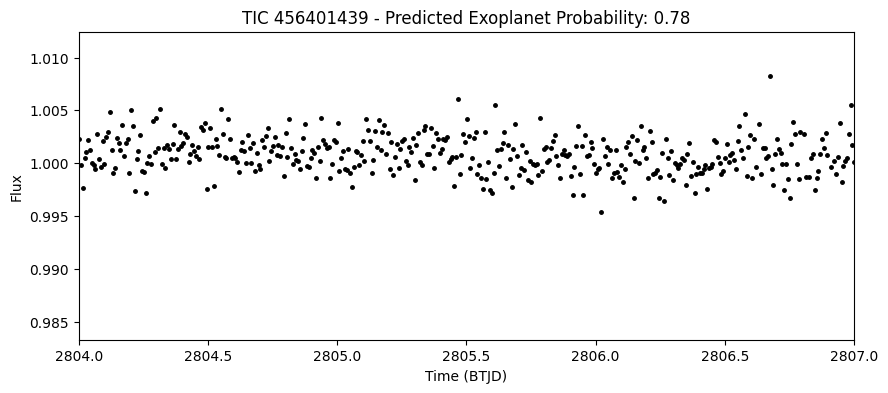

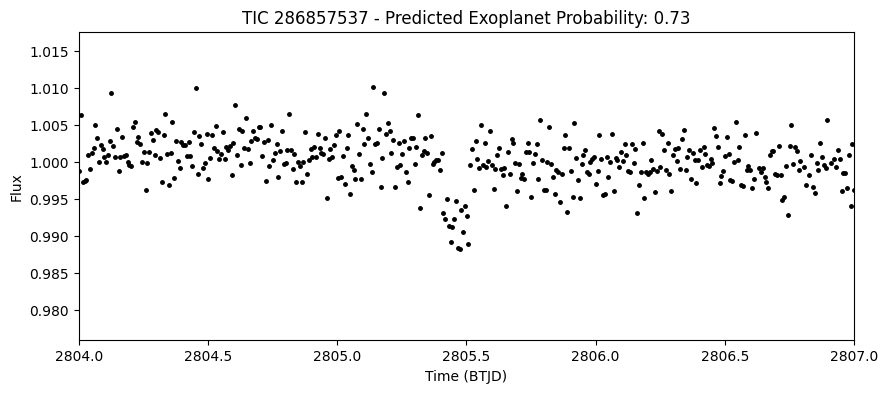

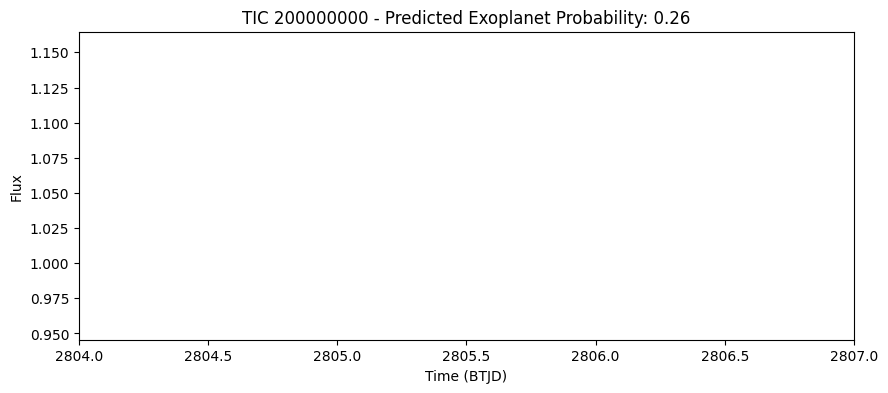

/usr/local/lib/python3.12/dist-packages/lightkurve/lightcurve.py:1154: LightkurveWarning: The light curve appears to be zero-centered (median=5.73e+02 electron / s +/- 6.85e+14 electron / s); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  warnings.warn(


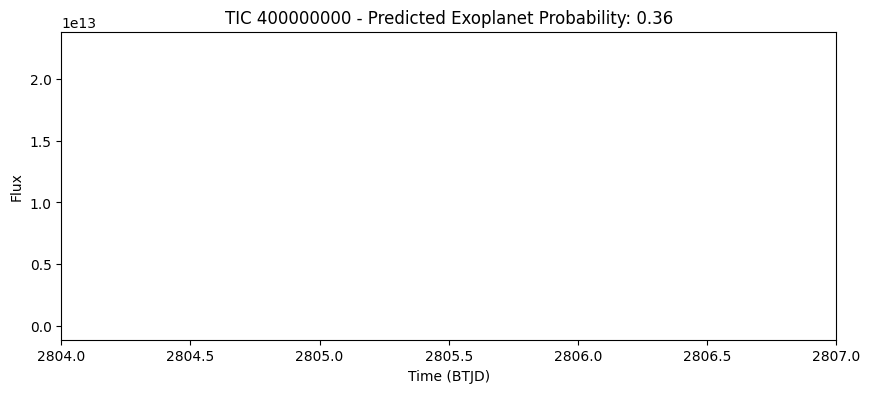

In [ ]:
for i, row in df.iterrows():
    try:
        lc = lk.search_lightcurve(row["TOI"], mission='TESS').download_all().stitch()
        lc_clean = lc[lc.quality == 0]

        if lc_clean is None or len(lc_clean) == 0:
            print(f"{row['TOI']}: No clean data available for visualization after quality filter.")
            continue

        X_row = row.drop(["label","TOI"]).to_frame().T
        prob = model.predict_proba(X_row)[0][1]

        plt.figure(figsize=(10,4))
        plt.plot(lc_clean.time.value, lc_clean.flux.value, 'k.', markersize=5)
        plt.title(f"{row['TOI']} - Predicted Exoplanet Probability: {prob:.2f}")
        plt.xlim(2804, 2807)
        plt.xlabel("Time (BTJD)")
        plt.ylabel("Flux")
        plt.show()
    except Exception as e:
        print(f"{row['TOI']} visualization failed: {e}")

### 특징 분포 시각화

추출된 특징(`df` DataFrame에 저장됨)의 분포를 히스토그램과 박스플롯으로 시각화합니다.

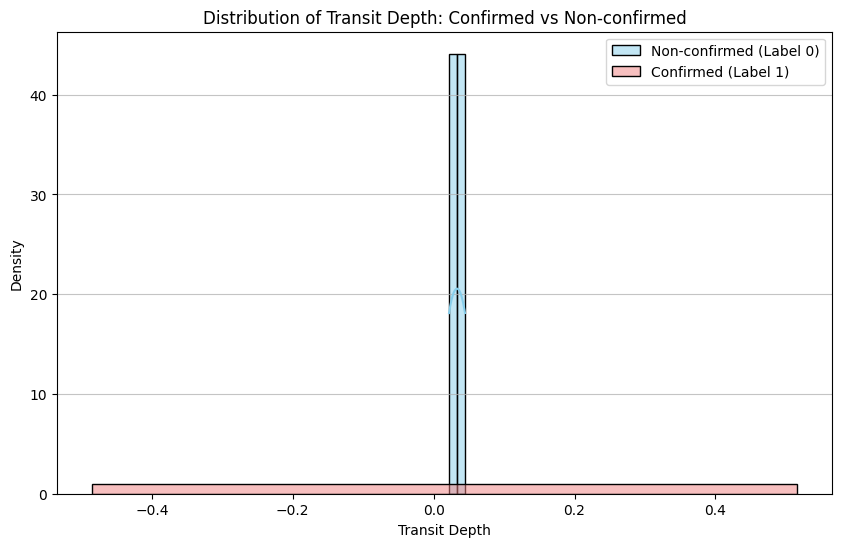

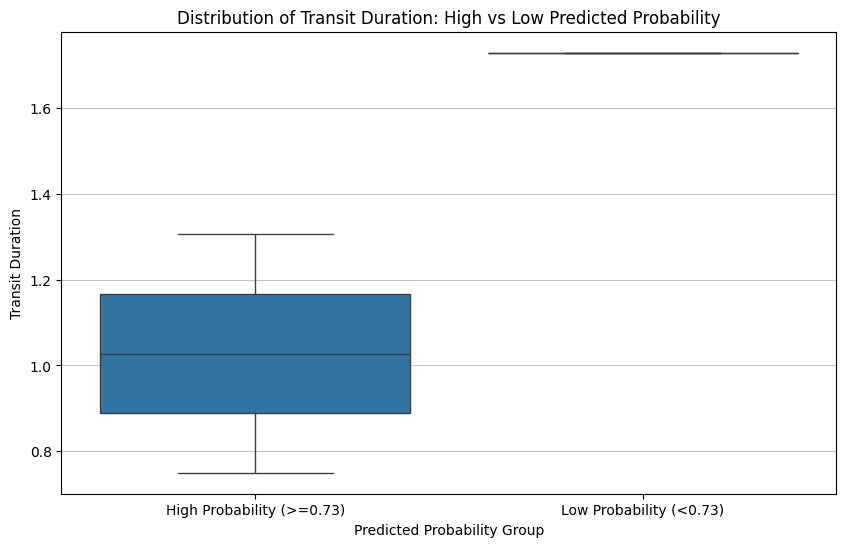

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

if 'df' in locals() and not df.empty:

    # 1. transit_depth histplot: compare confirmed (label=1) vs non-confirmed (label=0)

    # seperate data with label 0 and 1
    df_label_0 = df[df['label'] == 0].dropna(subset=['transit_depth'])
    df_label_1 = df[df['label'] == 1].dropna(subset=['transit_depth'])

    plt.figure(figsize=(10, 6))
    sns.histplot(df_label_0['transit_depth'], color='skyblue', label='Non-confirmed (Label 0)', kde=True, stat="density", common_norm=False)
    sns.histplot(df_label_1['transit_depth'], color='lightcoral', label='Confirmed (Label 1)', kde=True, stat="density", common_norm=False)
    plt.title('Distribution of Transit Depth: Confirmed vs Non-confirmed')
    plt.xlabel('Transit Depth')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    # 2. compare high prediction TOI vs. low prediction TOI

    if 'model' in locals() and hasattr(model, 'predict_proba'):
        try:
            # calculate prediction probbability for each TOI of DataFrame
            df_predict = df.dropna(subset=df.columns.drop(['label', 'TOI'])).copy()

            if not df_predict.empty:
                X_pred_features = df_predict.drop(["label","TOI"], axis=1)

                y_prob_all = model.predict_proba(X_pred_features)

                if y_prob_all.shape[1] > 1:
                     df_predict['predicted_prob'] = y_prob_all[:, 1]
                else:
                     # when model training data isn't enough
                     df_predict['predicted_prob'] = y_prob_all[:, 0] if model.classes_[0] == 1 else 0.0


                # seperate groups by the prediction probability
                prob_median = df_predict['predicted_prob'].median()
                df_predict['prob_group'] = df_predict['predicted_prob'].apply(
                    lambda x: f'High Probability (>={prob_median:.2f})' if x >= prob_median else f'Low Probability (<{prob_median:.2f})'
                )

                # transit_duration boxplot
                plt.figure(figsize=(10, 6))
                sns.boxplot(x='prob_group', y='transit_duration', data=df_predict.dropna(subset=['transit_duration']))
                plt.title('Distribution of Transit Duration: High vs Low Predicted Probability')
                plt.xlabel('Predicted Probability Group')
                plt.ylabel('Transit Duration')
                plt.grid(axis='y', alpha=0.75)
                plt.show()

            else:
                print("there are no valid data to calculate prediction probability calculation.")


        except Exception as e:
            print(f"error while calculating: {e}")

    else:
        print("model is not trained yet.")

else:
    print("DataFrame(df) is empty")

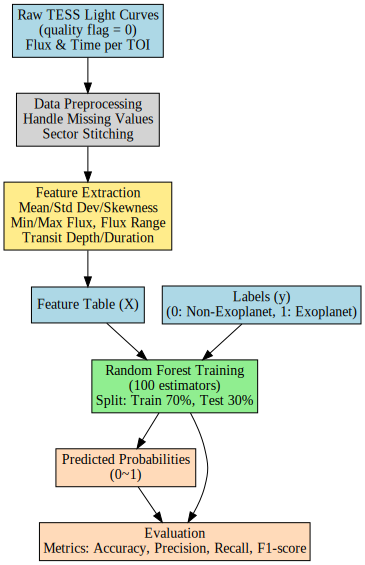

In [ ]:
import graphviz

dot = graphviz.Digraph(comment='Exoplanet Classification Pipeline', format='png')

dot.node('A', 'Raw TESS Light Curves\n(quality flag = 0)\nFlux & Time per TOI', shape='box', style='filled', fillcolor='lightblue')
dot.node('B', 'Data Preprocessing\nHandle Missing Values\nSector Stitching', shape='box', style='filled', fillcolor='lightgrey')
dot.node('C', 'Feature Extraction\nMean/Std Dev/Skewness\nMin/Max Flux, Flux Range\nTransit Depth/Duration', shape='box', style='filled', fillcolor='lightgoldenrod1')
dot.node('D', 'Feature Table (X)', shape='box', style='filled', fillcolor='lightblue')
dot.node('E', 'Labels (y)\n(0: Non-Exoplanet, 1: Exoplanet)', shape='box', style='filled', fillcolor='lightblue')
dot.node('F', 'Random Forest Training\n(100 estimators)\nSplit: Train 70%, Test 30%', shape='box', style='filled', fillcolor='lightgreen')
dot.node('G', 'Predicted Probabilities\n(0~1)', shape='box', style='filled', fillcolor='peachpuff')
dot.node('H', 'Evaluation\nMetrics: Accuracy, Precision, Recall, F1-score', shape='box', style='filled', fillcolor='peachpuff')

dot.edge('A', 'B')
dot.edge('B', 'C')
dot.edge('C', 'D')
dot.edge('D', 'F')
dot.edge('E', 'F')
dot.edge('F', 'G')
dot.edge('F', 'H')
dot.edge('G', 'H')

display(dot)

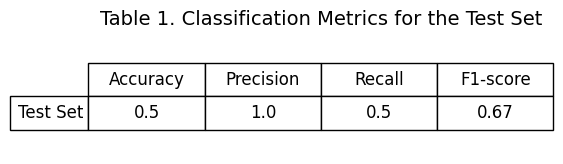

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

if 'y_test' in locals() and 'y_pred' in locals() and len(y_test) > 0:
    metrics = {
        "Accuracy": [accuracy_score(y_test, y_pred)],
        "Precision": [precision_score(y_test, y_pred, average="weighted", zero_division=0)],
        "Recall": [recall_score(y_test, y_pred, average="weighted", zero_division=0)],
        "F1-score": [f1_score(y_test, y_pred, average="weighted", zero_division=0)]
    }

    df_metrics = pd.DataFrame(metrics, index=["Test Set"])

    df_metrics = df_metrics.round(2)

    fig, ax = plt.subplots(figsize=(6, 1.5))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df_metrics.values,
                     colLabels=df_metrics.columns,
                     rowLabels=df_metrics.index,
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)

    plt.title("Table 1. Classification Metrics for the Test Set", fontsize=14, pad=10)
    plt.show()
else:
    print("model traning isn't finsihed / test data invalid.")